# Linear Regression

In [1]:
!pip install d2l==1.0.3


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

- Initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01
- set bias 0

In [2]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()                                                      #상위 클래스('d2l.Module')의 초기화 메서드를 호출 -> 상위 클래스의 속성과 매서드를 초기화
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)    #Weight 값을 정규붕포를 따르는 랜덤 값으로 초기화, gradient 계산하도록 설정
        self.b = torch.zeros(1, requires_grad=True)                             #Bias 값을 0으로 초기화, gradient 계산하도록 설정

- weight **w**, input features **X**, bias **b**(scalar)

In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #forward 메서드 추가
def forward(self, X):
    return torch.matmul(X, self.w) + self.b # 입력 데이터 X와 모델의 가중치 self.w를 행렬 곱한 gn 편향 self.b를 더해줌.

## Defining the Loss Function

- transform true value y into the predicted value's shape y_hat
- averaged loss value를 최종결과로 return

In [4]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y.reshape(y_hat.shape))**2 / 2 (MSE)
    return l.mean()

<>:3: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:3: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\장건호\AppData\Local\Temp\ipykernel_21456\2068237569.py:3: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  l = (y_hat - y.reshape(y_hat.shape))**2 / 2 (MSE)


## Defining the Optimization Algorithm

과제는 아니지만, 전체적인 deep learning pipeline을 파악해주세요!

In [5]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()             #하이퍼파라미터 저장

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad       #학습률과 기울기 곱한 값을 기존 값에서 뺌.

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()              #기울기 초기화

In [6]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)       # 모델의 가중치(self.w)와 편향(self.b)를 최적화하기 위해 SGD 최적화 알고리즘을 설정합니다.

##Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [7]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()                                                      #학습모드로 모델 전환
    for batch in self.train_dataloader:                                     #데이터로더로부터 배치 가져오기
        loss = self.model.training_step(self.prepare_batch(batch))          #배치 가져와서 학습하고 로스 계산
        self.optim.zero_grad()                                              #기울기 초기화
        with torch.no_grad():                                               #기울기 계산X 설정
            loss.backward()                                                 #손실 값 기반 역전파 수행
            if self.gradient_clip_val > 0:  # To be discussed later         #기울기 클리핑(발산 방지) 값 설정되어 있을 경우
                self.clip_gradients(self.gradient_clip_val, self.model)     #기울기 클리핑 진행
            self.optim.step()                                               #최적화-> 파라미터 업데이트
        self.train_batch_idx += 1                                           #배치 인덱스 증가
    if self.val_dataloader is None:                                         #검증 단계 별도로 없으면 종료
        return
    self.model.eval()                                                       #평가 모드로 전환
    for batch in self.val_dataloader:                                       #검증 데이터 가져오기
        with torch.no_grad():                                               #기울기 계산 하지 않도록 설정
            self.model.validation_step(self.prepare_batch(batch))           #배치 준비 후 모델 검증
        self.val_batch_idx += 1                                             #검증 배치 인덱스 증가

loss를 확인해봅시다 !

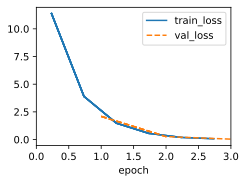

In [11]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)        #합성데이터 생섣
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

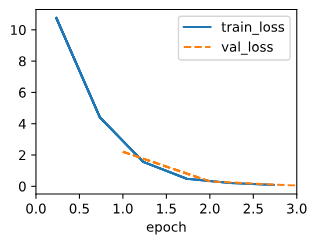

-정답 그림

# Softmax Regression

다양한 X를 설정해서 진행해주셔도 좋을 거 같습니다 :>

In [8]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)            #keepdims -> 텐서 차원 유지

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

softmax를 구현해주세요

In [9]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1, keepdims=True)
    
    return (X_exp)/(partition)

In [10]:
X = torch.rand((2, 5))      #2X5행렬 생성
X_prob = softmax(X)
X_prob, X_prob.sum(1)       #행들끼리 합

(tensor([[0.1671, 0.1707, 0.2196, 0.1819, 0.2607],
         [0.2072, 0.2483, 0.1472, 0.2091, 0.1881]]),
 tensor([1.0000, 1.0000]))

## Model

- 28*28 pixel image를 가지고, flatten하여 vector로 만듦
- 10 class 존재

In [11]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()                                         #하이퍼파라미터 저장
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)                           #가중치 행렬 초기화(정규분포)
        self.b = torch.zeros(num_outputs, requires_grad=True)               #쳔향 벡터 0으로 초기화

    def parameters(self):
        return [self.W, self.b]

In [18]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))                      #(배치크기, 입력 특성 수)
    return softmax(torch.matmul(X, self.W) + self.b)

## Cross-Entropy Loss

다양한 y로 연습해보셔도 좋을 거 같습니다 :>

In [14]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Cross entropy loss를 구현해주세요

In [15]:
def cross_entropy(y_hat, y):
    probs = y_hat[range(len(y_hat)), y]     #샘플의 인덱스 리스트 생성

    log_probs = -torch.log(probs)           #확률 값 -> log, 음수부호
    return log_probs.mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [16]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

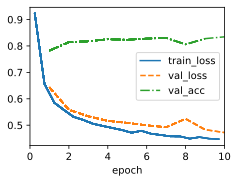

In [19]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)        #28x28픽셀 -> https://ko.d2l.ai/chapter_deep-learning-basics/softmax-regression-scratch.html
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

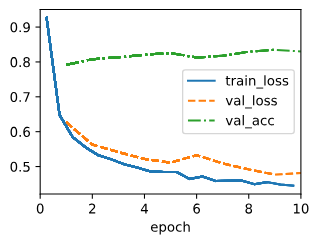

-정답 그림

## Prediction

어떤 방식으로 prediction 및 사진이 나오는지 확인해주세요

In [20]:
X, y = next(iter(data.val_dataloader()))        #배치 가져옴
preds = model(X).argmax(axis=1)                 #가장 높은 확률의 클래스 인덱스 반환
preds.shape

torch.Size([256])

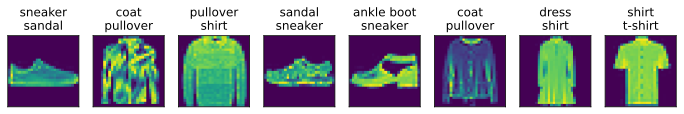

In [21]:
wrong = preds.type(y.dtype) != y                    #예측레이블과 실제레이블이 일치하지 않는 위치를 나타내는 텐서 생성
X, y, preds = X[wrong], y[wrong], preds[wrong]      #예측 틀린 샘플들만 분류
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]  #샘플링한 레이블을 시각화하기 위해 쌍으로 묶음
data.visualize([X, y], labels=labels)

# Review

## Numpy version

### data generation

In [22]:
import numpy as np

true_b = 1
true_w = 2

N = 100

np.random.seed(42)
x = np.random.rand(N,1)  # Uniform
epsilon = (0.1 * np.random.randn(N,1))  # standard normal dist  # noise
y = true_w*x + true_b + epsilon

### train-validation split

In [23]:
# Shuffles the indices
idx = np.arange(N)
split_index = int(N * 0.8)

train_idx = idx[:split_index]
val_idx = idx[split_index:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

### gradient descent for linear regression

In [24]:
# 실행시간을 측정해주는 Decorator 입니다.

import time
def timer(func):
  def wrapper(*args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"Execution time of {func.__name__}: {computation_time} seconds")
    return result
  return wrapper

In [25]:
@timer
def train_model_numpy(lr = 0.1, epochs = 1000):
  # Initialize parameters
  b = np.random.randn(1)
  w = np.random.randn(1)

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train
    error = (y_hat - y_train)
    mse_loss = (error**2).mean()

    # Gradient computation
    b_grad = 2*error.mean()
    w_grad = 2*(x_train*error).mean()
    b = b - lr * b_grad
    w = w - lr * w_grad
  return b, w


In [26]:
b, w = train_model_numpy()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_numpy: 0.014406442642211914 seconds
b_estimate:[1.02341376], w_estimate:[1.93680725]


## Pytorch version

### data generation

In [27]:
import torch

# create tensor at CPU:
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

# create tensor ar GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)


### gradient descent

In [28]:
@timer
def train_model_torch(lr = 0.1, epochs=1000):
  # Initialize parameters
  b = torch.randn(1, requires_grad=True)
  w = torch.randn(1, requires_grad=True)

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train_tensor
    error = (y_hat - y_train_tensor)
    mse_loss = (error**2).mean()
    # Gradient computation and descent
    mse_loss.backward()
    with torch.no_grad():
      b -= lr * b.grad                    # in-place operation
      w -= lr * w.grad                    # 경사 하강법 할 땐 auto grad 끄고 하는 게 좋죠!
    
    b.grad.zero_()                        # gradient 초기화 시켜줘야해요. 안 하면 누적합으로 계산하기 때문에!
    w.grad.zero_()
  return b, w

In [29]:
b, w = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_torch: 0.08735227584838867 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)


### additional -> optimizer를 사용하기 (gradient descent)

In [30]:
import torch.optim as optim
import torch.nn as nn

@timer
def train_model_torch(lr = 0.1, epochs=1000):
  # Initialize parameters
  b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  w = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  parameters = [b, w]
  optimizer = optim.SGD(parameters, lr = lr)                    #1.optimizer활용하여 경사하강법 처리
  mse_loss = nn.MSELoss()

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train_tensor                              #2.MSE 계산 -> 수동 아닌 nn.MSELoss 활용  
    loss = mse_loss(y_hat, y_train_tensor)
    # Gradient computation and descent
    loss.backward()
    optimizer.step()                                            # 경사하강법 연산, step 한 번을 밟는다!
    optimizer.zero_grad()                                       
  return b, w

In [31]:
b, w = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_torch: 0.32686448097229004 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)
